## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import tensorflow as tf

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = tf.keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = tf.keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from tensorflow.keras.regularizers import l1, l2, l1_l2
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = tf.keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = tf.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = tf.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = tf.keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = tf.keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = tf.keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = tf.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = tf.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = tf.keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = tf.keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1_L2=[1e-2, 1e-4, 1e-8, 1e-12]

In [11]:
results = {}
for regulizer_ratio in L1_EXP:
    tf.keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples,

50000/50000 [==============================] - 8s 156us/sample - loss: 2.4626 - acc: 0.0969 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 8s 155us/sample - loss: 2.4626 - acc: 0.0994 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 8s 157us/sample - loss: 2.4626 - acc: 0.0973 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 8s 155us/sample - loss: 2.4626 - acc: 0.0980 - val_loss: 2.4627 - val_acc: 0.1000
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (

50000/50000 [==============================] - 8s 161us/sample - loss: 2.7518 - acc: 0.6233 - val_loss: 3.0188 - val_acc: 0.5174
Epoch 48/50
50000/50000 [==============================] - 8s 161us/sample - loss: 2.7161 - acc: 0.6248 - val_loss: 2.9664 - val_acc: 0.5325
Epoch 49/50
50000/50000 [==============================] - 8s 161us/sample - loss: 2.6769 - acc: 0.6264 - val_loss: 3.0846 - val_acc: 0.4970
Epoch 50/50
50000/50000 [==============================] - 8s 161us/sample - loss: 2.6430 - acc: 0.6274 - val_loss: 2.9364 - val_acc: 0.5196
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (

50000/50000 [==============================] - 10s 191us/sample - loss: 0.9038 - acc: 0.6849 - val_loss: 1.4084 - val_acc: 0.5246
Epoch 48/50
50000/50000 [==============================] - 9s 185us/sample - loss: 0.8925 - acc: 0.6893 - val_loss: 1.3667 - val_acc: 0.5324
Epoch 49/50
50000/50000 [==============================] - 9s 185us/sample - loss: 0.8796 - acc: 0.6921 - val_loss: 1.5925 - val_acc: 0.4769
Epoch 50/50
50000/50000 [==============================] - 9s 183us/sample - loss: 0.8750 - acc: 0.6932 - val_loss: 1.3875 - val_acc: 0.5303
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 

50000/50000 [==============================] - 9s 173us/sample - loss: 0.9167 - acc: 0.6772 - val_loss: 1.3684 - val_acc: 0.5385
Epoch 48/50
50000/50000 [==============================] - 8s 160us/sample - loss: 0.9038 - acc: 0.6809 - val_loss: 1.3643 - val_acc: 0.5387
Epoch 49/50
50000/50000 [==============================] - 8s 158us/sample - loss: 0.8911 - acc: 0.6867 - val_loss: 1.3959 - val_acc: 0.5304
Epoch 50/50
50000/50000 [==============================] - 8s 158us/sample - loss: 0.8806 - acc: 0.6891 - val_loss: 1.4554 - val_acc: 0.5184


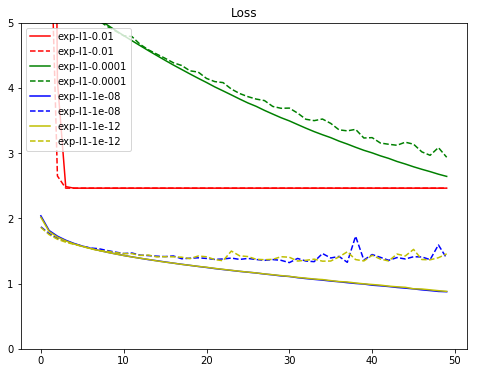

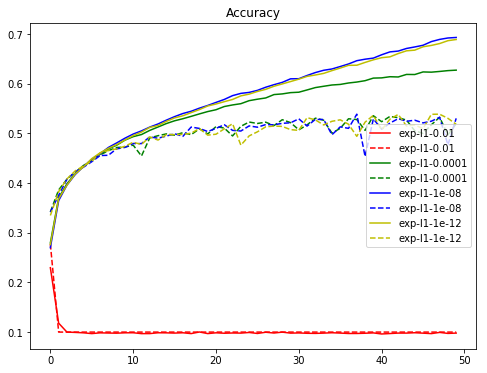

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [13]:
results = {}
for regulizer_ratio in L1_L2:
    tf.keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Epoch 1/50
50000/50000 [==============================] - 8s 166us/sample - loss: 5.9890 - acc: 0.2791 - val_loss: 5.8044 - val_acc: 0.3432
Epoch 2/50
50000/50000 [==============================] - 8s 157us/sample - loss: 5.7101 - acc: 0.3699 - val_loss: 5.6371 - val_acc: 0.3846
Epoch 3/50
50000/50000 [==============================] - 8s 156us/sample - loss: 5.5643 - acc: 0.4009 - val_loss: 5.4993 - val_acc: 0.4100
Epoch 4/50
50000/50000 [==============================] - 8s 156us/sample - loss: 5.4438 - acc: 0.4191 - val_loss: 5.3872 - val_acc: 0.4246
Epoch 5/50
50000/50000 [==============================] - 8s 157us/sample - loss: 5.3355 - acc: 0.4341 - val_loss: 5.2895 - val_acc: 0.4410
Epoch 6/50
50000/50000 [==============================] - 8s 156us/sample - loss: 5.2379 - acc: 0.4477 - val_loss: 5.2070 - val_acc: 0.4428
Epoch 7/50
50000/50000 [==============================] - 8s 156us/sample - loss: 5.1428 - acc: 0.4602 - val_loss: 5.1152 - val_acc: 0.4571
Epoch 8/50
50000/500

50000/50000 [==============================] - 8s 165us/sample - loss: 2.0301 - acc: 0.2733 - val_loss: 1.8682 - val_acc: 0.3382
Epoch 2/50
50000/50000 [==============================] - 8s 155us/sample - loss: 1.8053 - acc: 0.3646 - val_loss: 1.7661 - val_acc: 0.3777
Epoch 3/50
50000/50000 [==============================] - 8s 154us/sample - loss: 1.7212 - acc: 0.3970 - val_loss: 1.6903 - val_acc: 0.4027
Epoch 4/50
50000/50000 [==============================] - 8s 155us/sample - loss: 1.6602 - acc: 0.4191 - val_loss: 1.6378 - val_acc: 0.4271
Epoch 5/50
50000/50000 [==============================] - 8s 155us/sample - loss: 1.6142 - acc: 0.4339 - val_loss: 1.5965 - val_acc: 0.4388
Epoch 6/50
50000/50000 [==============================] - 8s 154us/sample - loss: 1.5733 - acc: 0.4496 - val_loss: 1.5720 - val_acc: 0.4382
Epoch 7/50
50000/50000 [==============================] - 8s 154us/sample - loss: 1.5414 - acc: 0.4571 - val_loss: 1.5438 - val_acc: 0.4541
Epoch 8/50
50000/50000 [=======

50000/50000 [==============================] - 8s 164us/sample - loss: 2.0401 - acc: 0.2727 - val_loss: 1.8656 - val_acc: 0.3438
Epoch 2/50
50000/50000 [==============================] - 8s 154us/sample - loss: 1.8046 - acc: 0.3647 - val_loss: 1.7542 - val_acc: 0.3832
Epoch 3/50
50000/50000 [==============================] - 8s 155us/sample - loss: 1.7218 - acc: 0.3978 - val_loss: 1.6854 - val_acc: 0.4112
Epoch 4/50
50000/50000 [==============================] - 8s 155us/sample - loss: 1.6625 - acc: 0.4170 - val_loss: 1.6426 - val_acc: 0.4193
Epoch 5/50
50000/50000 [==============================] - 8s 156us/sample - loss: 1.6141 - acc: 0.4341 - val_loss: 1.5976 - val_acc: 0.4341
Epoch 6/50
50000/50000 [==============================] - 9s 178us/sample - loss: 1.5721 - acc: 0.4496 - val_loss: 1.5643 - val_acc: 0.4507
Epoch 7/50
50000/50000 [==============================] - 8s 167us/sample - loss: 1.5369 - acc: 0.4611 - val_loss: 1.5403 - val_acc: 0.4579
Epoch 8/50
50000/50000 [=======

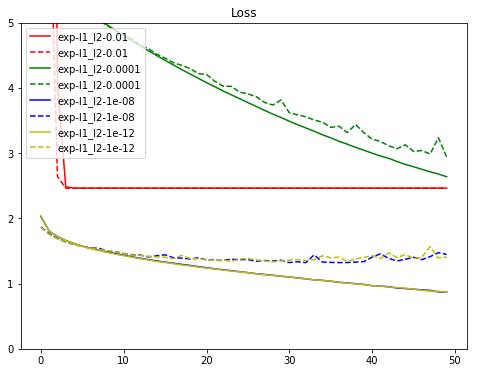

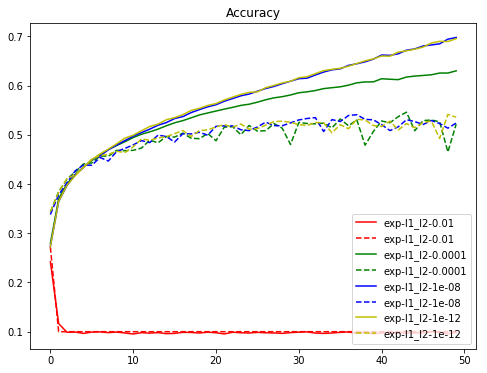

In [14]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()